In [1]:
############################
### import modules

import sys
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import csv
import io
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import astropy
from astropy import stats
from scipy import interpolate
import os

###########################

np.set_printoptions(suppress=True)
os.chdir("../data")  # moves working directory to data folder

In [34]:
############################
### user inputs 

SSMfluxB8 = 5.46e6 #/ cm^2 s  SSM variant: B16-GS98, uncer = 12%
SNOfluxB8 = 5.25e6   # add SNO B8 flux measurement

inEres = 0.15 # assumed percentage energy resolution at 1 MeV

Smd12 = 5.13e-5 # global solar mass-squared diff
Rmd12 = 7.53e-5 # reactor " "

Sa12 =  33.4   #theta12 solar
Ra12 = 33.4

###Efficiency
eff = 0.38

#############################

flux_perc = 3.8 #%
cross_perc = 10 #%
spect_perc= 4   #%
effic_perc = 10 #%

numflux = SNOfluxB8 

####Factors

nt = 10e31 # number of target atoms in 10kT LAr module
fac = 1e-42 # cross-section factor


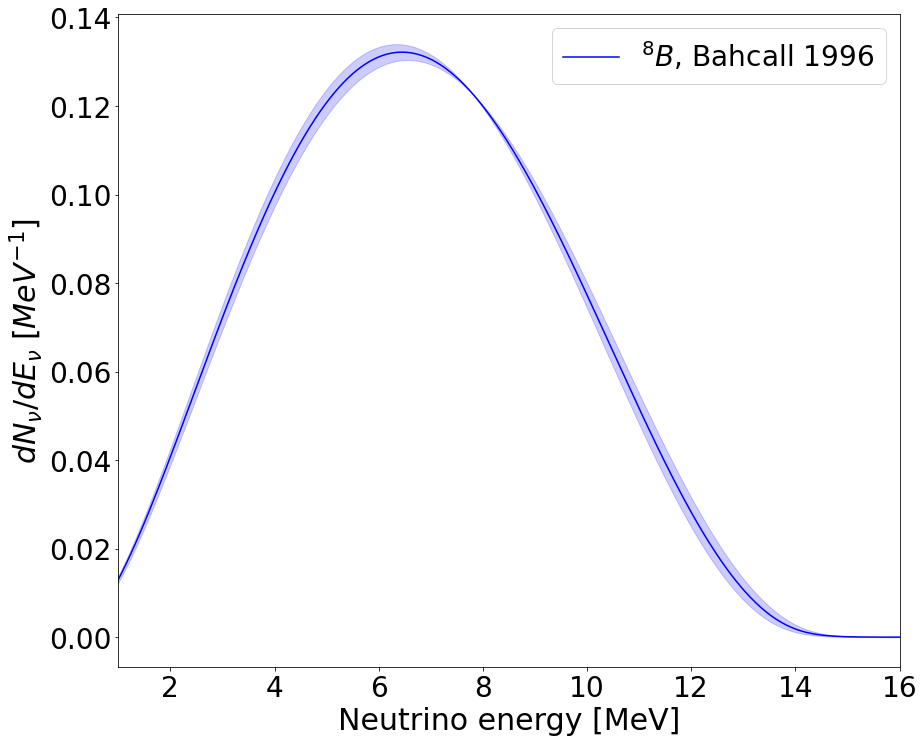

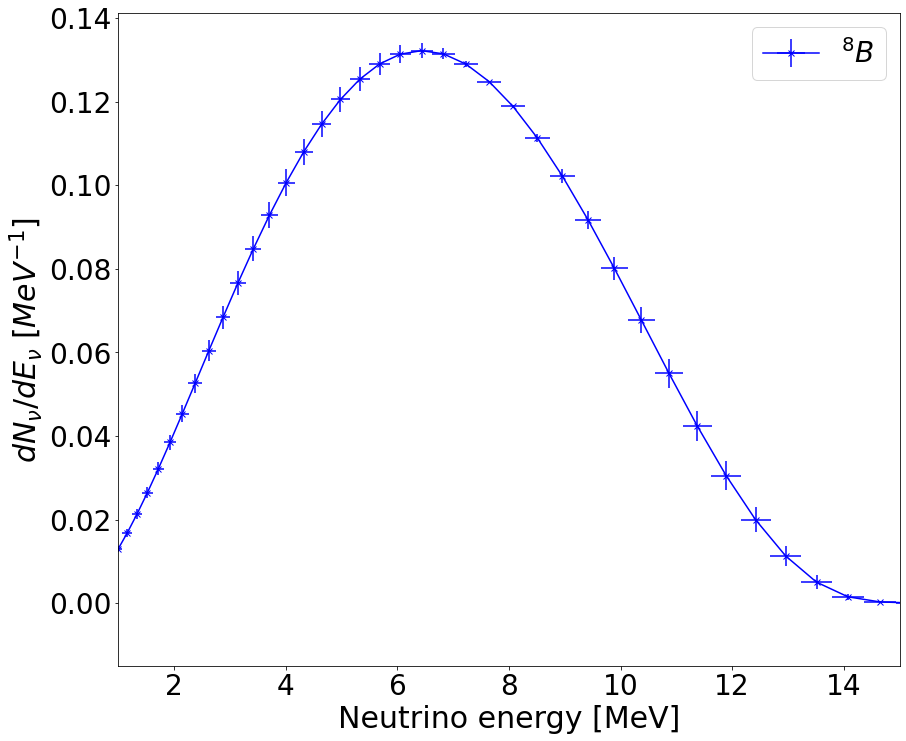

Energy: array([ 1.        ,  1.16216216,  1.3359588 ,  1.52136497,  1.71835876,
        1.92692075,  2.14703366,  2.37868194,  2.62185162,  2.87653001,
        3.14270555,  3.42036769,  3.70950674,  4.01011377,  4.32218054,
        4.64569939,  4.98066323,  5.32706544,  5.68489983,  6.05416062,
        6.43484238,  6.82694   ,  7.23044867,  7.64536386,  8.07168129,
        8.50939689,  8.95850683,  9.41900744,  9.89089528, 10.37416702,
       10.86881953, 11.37484981, 11.892255  , 12.42103234, 12.96117923,
       13.51269314, 14.07557169, 14.64981254, 15.23541349, 15.83237241,
       16.44068724, 17.06035602, 17.69137683, 18.33374785])
Flux spectrum: array([0.0130196 , 0.01686325, 0.02133887, 0.0264427 , 0.03216861,
       0.03847747, 0.04532911, 0.05265542, 0.06037449, 0.06838046,
       0.07655913, 0.0847615 , 0.09283745, 0.10062471, 0.10794962,
       0.11462969, 0.12048889, 0.12533928, 0.12901009, 0.13133332,
       0.13217095, 0.13140534, 0.12895508, 0.12477494, 0.11886679,
      

In [10]:
### imports energy spectrum shape

cserr = cross_perc/100

EvB8 = np.array([])
EvdataB8 = np.array([])
EvB8uncer_ = np.array([])
EvB8uncer__ = np.array([])
with open('bahcallB8spectrum.csv', 'r') as file: # should add commas to this file
    reader = csv.reader(file)
    for row in reader:
        temp = row[0].split()
        EvB8 = np.append(EvB8, float(temp[0])) # energy values
        EvdataB8 = np.append(EvdataB8, float(temp[1])) # normalisation units
        EvB8uncer_ = np.append(EvB8uncer_, float(temp[2]))
        EvB8uncer__ = np.append(EvB8uncer__, float(temp[3]))
    
### plot energy spectrum 

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

poptB8, pcovB8 = curve_fit(gaus, EvB8, EvdataB8)

###############################

### variable bin widths based on energy resolution

x = 1 # corresponds to 1 MeV
sigmawidth = 0.5 # corresponds to a bin width of 1 sigma, controls bin purity

points = np.array([x])
uncer = np.array([inEres*sigmawidth*x])
edges = np.array([x - inEres*sigmawidth*x, x + inEres*sigmawidth*x])

while x < 18:
    Eres = inEres/x**0.5 # adds energy dependence
    xtemp = x*((1+sigmawidth*Eres)/(1-sigmawidth*Eres)) # relation to the next data point
    uncertemp = Eres*sigmawidth*xtemp
    
    uncer = np.append(uncer, uncertemp)
    points = np.append(points, xtemp)
    edges = np.append(edges, xtemp+ Eres*sigmawidth*xtemp)
    
    x = xtemp

xdata = points
bwidth = 2*uncer

###############################

plt.figure(figsize=(14,12))

#plt.errorbar(EvB8, EvdataB8, yerr=EvB8uncer, marker="x", color="blue", label=r'${}^{8}B$') # add yerrs from csv file
plt.plot(EvB8, EvdataB8, color='blue', label=r'${}^{8}B$, Bahcall $1996$')
plt.fill_between(EvB8, EvB8uncer_, EvB8uncer__, color='blue', alpha=0.2)


plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.ylabel(r'$d N_{\nu}/d E_{\nu}$ [$MeV^{-1}$]',fontsize=30)
plt.xticks(fontsize=28)

plt.yticks(fontsize=28)
#plt.yscale('log')

plt.legend(fontsize=28)
plt.xlim(1,16)

plt.savefig('../figures/B8spectrum.png', bbox_inches='tight')

plt.show()


###############################

tckB8 = interpolate.splrep(EvB8, EvdataB8)
yB8 = interpolate.splev(xdata, tckB8, der=0)

tckB8_ = interpolate.splrep(EvB8, EvB8uncer_)
uncerB8_ = interpolate.splev(xdata, tckB8_, der=0)

tckB8__ = interpolate.splrep(EvB8, EvB8uncer__)
uncerB8__ = interpolate.splev(xdata, tckB8__, der=0)

yB8[yB8 < 0] = 0 # removes negative values
fluxspec = yB8 

specerr = 0.5*((uncerB8_ - uncerB8__)**2)**0.5

plt.figure(figsize=(14,12))

plt.errorbar(xdata, yB8, xerr=uncer, yerr=specerr, marker="x", color="blue", label=r'${}^{8}B$') 

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.ylabel(r'$d N_{\nu}/d E_{\nu}$ [$MeV^{-1}$]',fontsize=30)
plt.xticks(fontsize=28)

plt.yticks(fontsize=28)
#plt.yscale('log')

plt.legend(fontsize=28)
plt.xlim(1,15)

#plt.savefig('../figures/B8spectrum.png', bbox_inches='tight')

plt.show()

print('Energy:', repr(xdata[0:len(fluxspec)]))
print('Flux spectrum:', repr(fluxspec))
print('Peak energy:', xdata[fluxspec == np.max(fluxspec)])
print('Normalisation:', np.sum(yB8*bwidth))
print('Data points:', xdata)
print('Bin widths:', bwidth)

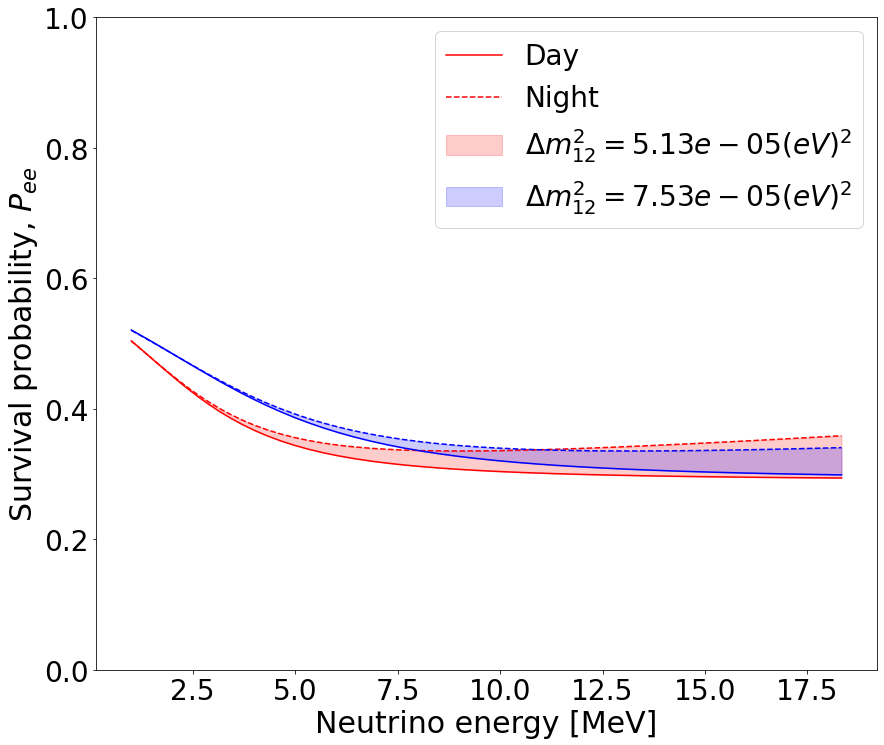

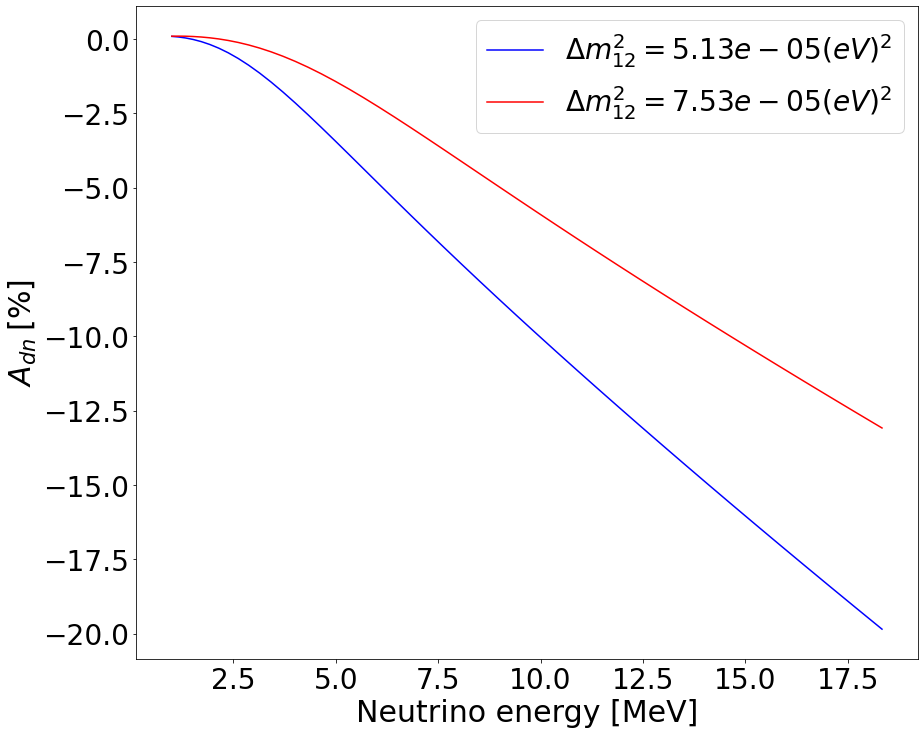

Asymmetry at peak energy: (array([0.35699135]), array([0.36647985]), array([-0.0262305]))


In [11]:
def asym(E, md12, a12): # input energy peak and mass-squared diff 21
    
    E = E*1e6 # energy peak of sensitivity curve, assuming asymmetric distribution
    degrad = math.pi/180 # deg.s to rad.s conversion factor
    Gf =  8.958e-44  #eV m3, Fermi constant
    
    ######################################
    # solar input parameters
    
    cMSW = 1 # divergence from msw theory
    peS = 92.5e3/1.673e-27 # m-3, e density of Sun at B8 production point 
    peE = 2.8e3/1.673e-27 # m-3, average e density of Earth 
    # add eccentricity (https://arxiv.org/abs/1506.08158)

    ######################################
    # oscillation parameters:

    #md12 = 7.42e-5 #eV^2, mass-square diff. 
    md13 = 2.515e-3 #eV^2
    
    a12 = a12*degrad   # rad, mixing angle
    a13 = 8.57*degrad
    
    s13 = math.sin(a13)
    c13 = math.cos(a13)
    
    s12 = math.sin(a12)
    c12 = math.cos(a12)
    
    s2a12 = math.sin(2*a12)
    c2a12 = math.cos(2*a12)
    
    ######################################
    
    lrS = ((2*2**0.5)*Gf*cMSW*peS*E*(c13**2))/md12 # ratio of oscillation length and refraction length in Sun
    lrE = ((2*2**0.5)*Gf*cMSW*peE*E*(c13**2))/md12 # " " in Earth
    
    c2a12S = (c2a12 - lrS)/(1 - 2*lrS*c2a12 + lrS**2)**0.5 # mixing angle in Sun matter
    c2a12E = (c2a12 - lrE)/(1 - 2*lrE*c2a12 + lrE**2)**0.5 # " " in Earth
    
    s2a12E = np.sin(np.arccos(c2a12E))
    
    freg = 0.5*(c13**2)*lrE*(s2a12E**2) # regenerative factor
    
    pd = (c13**4)*(0.5 + 0.5*c2a12S*c2a12) + s13**4
    pn = pd - c2a12S*(c13**2)*freg
    
    asym = (2*c2a12S*(c13**2)*freg)/(2*pd - c2a12S*(c13**2)*freg)

    return pd, pn, asym

plt.figure(figsize=(14,12))

Spd, Spn, Sasym = asym(xdata, Smd12, Sa12) # solar day/night surv prob.
Rpd, Rpn, Rasym = asym(xdata, Rmd12, Sa12) # reactor " "

plt.plot(xdata, Spd, color="red", label=r'Day')
plt.plot(xdata, Spn, color="red", linestyle='dashed', label=r'Night')
plt.fill_between(xdata, Spd, Spn, color='red', alpha=0.2, label=r'$\Delta m_{12}^2 =' + repr(Smd12) + '(eV)^2$')

plt.plot(xdata, Rpd, color="blue")
plt.plot(xdata, Rpn, color="blue", linestyle='dashed')
plt.fill_between(xdata, Rpd, Rpn, color='blue', alpha=0.2, label=r'$\Delta m_{12}^2 =' + repr(Rmd12) + '(eV)^2$')

#plt.xscale('log')
#plt.yscale('log')

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel(r'Survival probability, $P_{ee}$',fontsize=30)
plt.yticks(fontsize=28)
plt.ylim(0,1)

plt.legend(fontsize=28)
plt.savefig('../figures/B8survprob.png', bbox_inches='tight')

plt.show()

##########################################

plt.figure(figsize=(14,12))

plt.plot(xdata, Sasym*100, color="blue", label=r'$\Delta m_{12}^2 =' + repr(Smd12) + '(eV)^2$')
plt.plot(xdata, Rasym*100, color="red", label=r'$\Delta m_{12}^2 =' + repr(Rmd12) + '(eV)^2$')

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel(r'$A_{dn~} [\%]$',fontsize=30)
plt.yticks(fontsize=28)

plt.legend(fontsize=28)
plt.savefig('../figures/B8asymE.png', bbox_inches='tight')

plt.show()

print('Asymmetry at peak energy:', asym(xdata[fluxspec == np.max(fluxspec)], Rmd12, Sa12))

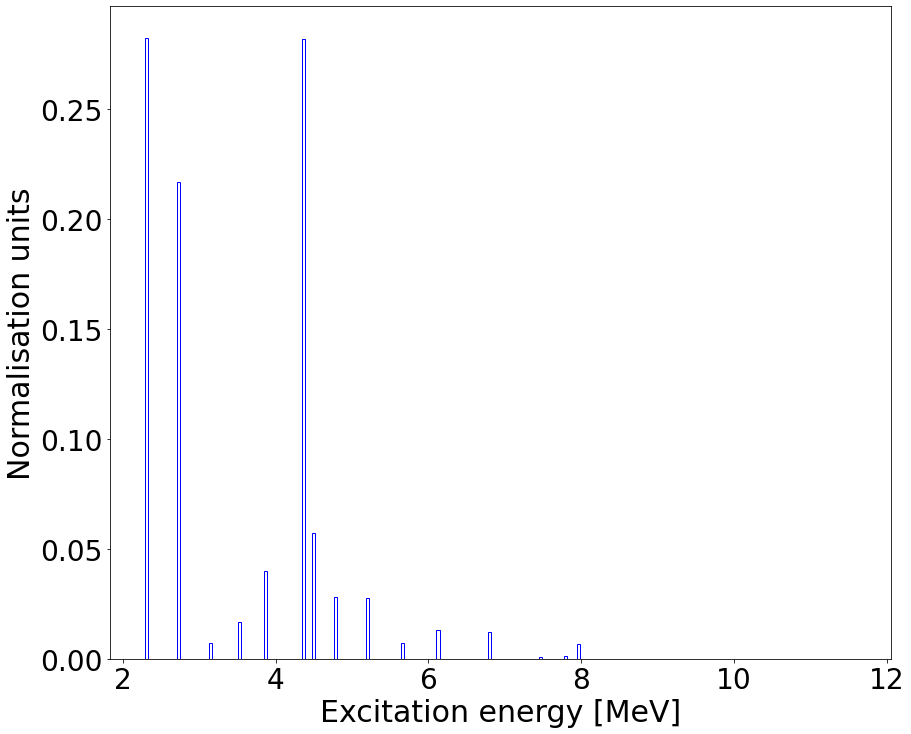

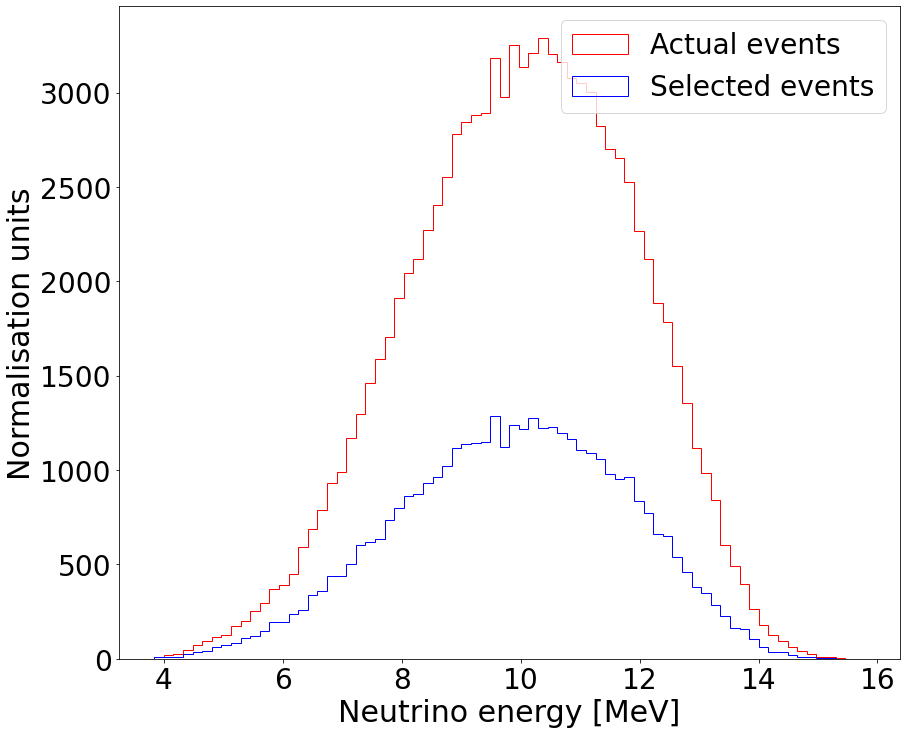

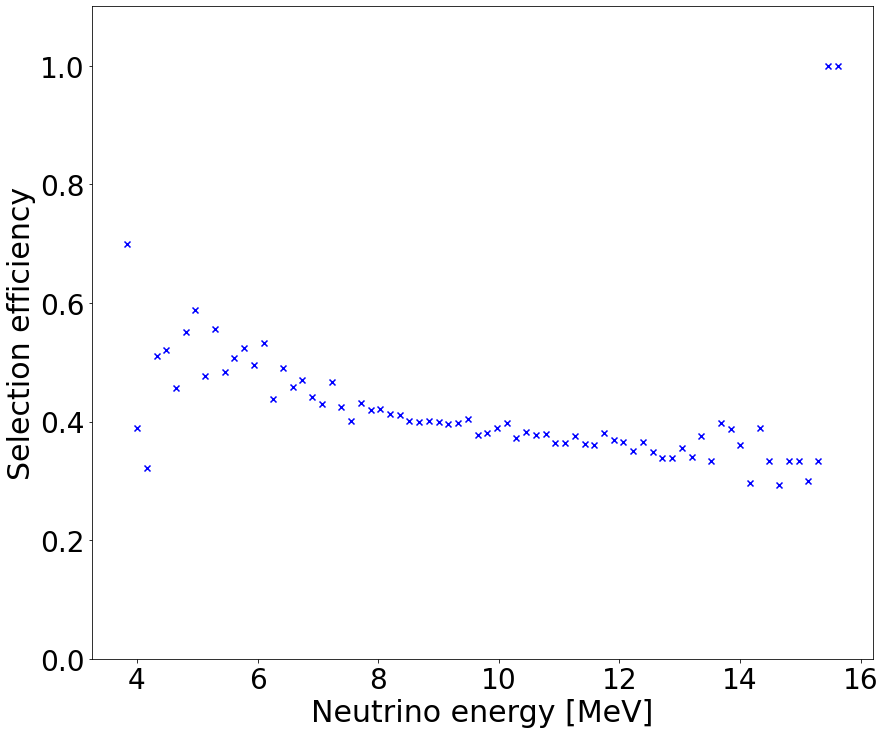

Mean selection efficiency: 0.38009795645151856


In [13]:
def optim_bins(mult_arry):
    # optimises bin widths based on Freedman rule of thumb, takes multidimensional array
    
    width_arry = np.array([])
    
    for arry in mult_arry: 
        width_temp = astropy.stats.freedman_bin_width(arry, return_bins=False)
        width_arry = np.append(width_arry, width_temp)
    
    energy_res = np.max(width_arry)
    flat_arry = np.concatenate(mult_arry, axis=0)
    
    return int(round((np.max(flat_arry) - np.min(flat_arry)) / energy_res, 0))

def hist_weights(rates, data):
    # returns weights of normalised histogram
    
    weights = []
    i = 0

    for event in data:
        weight = (rates[i]*np.ones_like(event))/len(event) #fraction = expected events / num of events generated
        weights.append(weight)
        i += 1
    
    return weights

def root_input(filename):
    # takes marsum configured MARLEY input file 
    
    rTree = uproot.open(filename)
    
    rTree_event = rTree['mst']
    Ex = np.array(rTree_event['Ex'])
    Ev = np.array(rTree_event['Ev'])
    KEl = np.array(rTree_event['KEl'])
    pdgp = np.array(rTree_event['pdgp'])
    Ep = np.array(rTree_event['Ep'])
    xsec = np.array(rTree_event['xsec'])
    
    return Ex, Ev, KEl, pdgp, Ep, xsec

filename = '/Users/Clara Escanuela/Downloads/B8_marsum.root'
Ex, Ev, KEl, pdgp, Ep, xsec = root_input(filename)

#####################################

plt.figure(figsize=(14,12))

data = [Ex]
rates = [1]

n, bins, patches = plt.hist(data, weights=hist_weights(rates,data), histtype='step', color='blue', bins=optim_bins(data), alpha=1)

plt.xlabel('Excitation energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Normalisation units',fontsize=30)
plt.yticks(fontsize=28)
#plt.yscale('log')

plt.savefig('../figures/excit.png', bbox_inches='tight')

plt.show()

###################################

numevents = 100000
data = np.concatenate([Ep[0:numevents]])

#prompt = np.array([])
selecEv = np.array([])

i = 0
for array in data:
    
    if any(1.6 < x < 1.616 for x in array):
        #prompt = np.append(prompt, KEl[i] + (np.sum(array)-1.614-0.03))
        selecEv = np.append(selecEv, Ev[i])

    i += 1
    
plt.figure(figsize=(14,12))

data = [selecEv, Ev[0:numevents]]
labels = ['Selected events', 'Actual events']

n, bins, patches = plt.hist(data, histtype='step', color=['blue', 'red'], label=labels, bins=optim_bins(data), alpha=1)

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Normalisation units',fontsize=30)
plt.yticks(fontsize=28)
#plt.yscale('log')

plt.legend(fontsize=28)

plt.show()

#################################

plt.figure(figsize=(14,12))

seleceff = n[0]/n[1]
bins = bins[0:len(seleceff)]

plt.scatter(bins, seleceff, color="blue", marker='x')

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)
plt.ylabel('Selection efficiency',fontsize=30)
plt.yticks(fontsize=28)
#plt.yscale('log')

plt.ylim(0,1.1)
#plt.legend(fontsize=28)

plt.show()

mseleceff = np.mean(seleceff[(bins > 8) & (bins < 13)])
print('Mean selection efficiency:', mseleceff)

Probabaility of detection: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00006783 0.00072144 0.00205168 0.00448917 0.00781675 0.01234827
 0.01866625 0.02812775 0.04177166 0.05752136 0.07704864 0.09855363
 0.12192661 0.14540932 0.16715588 0.18466422 0.1956875  0.19797316
 0.19121613 0.17460857 0.14723863 0.11098481 0.0726583  0.03759367
 0.01348674 0.00316251 0.00047186 0.00002655 0.         0.
 0.         0.        ]
Energy bins: [ 0.925       1.075       1.24932432  1.42890271  1.62008337  1.82284483
  2.03716811  2.26303638  2.50043454  2.74934898  3.0097674   3.28167858
  3.56507225  3.85993902  4.1662702   4.48405779  4.81329434  5.15397294
  5.50608715  5.86963096  6.2445987   6.63098511  7.02878518  7.43799424
  7.85860785  8.29062183  8.73403221  9.18883523  9.65502733 10.1326051
 10.62156531 11.12190489 11.6336209  12.15671052 12.69117107 13.23699998
 13.79419478 14.36275311 14.94267271 15.5339514  16.13

C:\Users\CLARAE~1\AppData\Local\Temp/ipykernel_1496/3311550382.py:9: RuntimeWarning: invalid value encountered in true_divide
  crosssec = (n*np.mean(xsec))/fluxspec # calculate cross section used in MARLEY


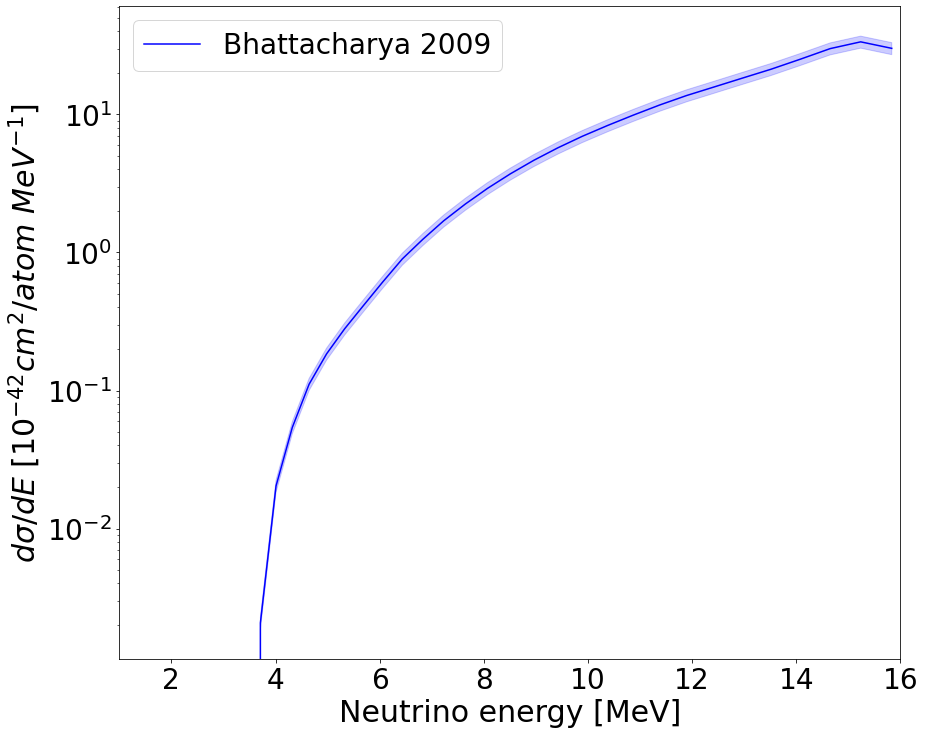

In [14]:
plt.figure(figsize=(14,12))

n, edges = np.histogram(Ev, edges, density=True) # bin edges taken

print('Probabaility of detection:', n)
print('Energy bins:', edges)
print('Flux averaged total cross section:', np.mean(xsec))

crosssec = (n*np.mean(xsec))/fluxspec # calculate cross section used in MARLEY

crosssec = crosssec

#plt.errorbar(xdata, crosssec, xerr=uncer, yerr=crosssec*cserr, marker='', color="blue", label=r'MARLEY cross section')
plt.plot(xdata, crosssec, color="blue", label=r'Bhattacharya 2009')
plt.fill_between(xdata, crosssec+0.1*crosssec, crosssec-0.1*crosssec, color='blue', alpha=0.2)

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.ylabel('$d\sigma/dE$ [$10^{-42} cm^{2}/atom\ MeV^{-1}$]',fontsize=30)

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

plt.legend(fontsize=28)

plt.xlim(1,16)
plt.yscale('log')
#plt.xscale('log')

plt.savefig('../figures/crosssec.png', bbox_inches='tight')

plt.show()

5250000.0


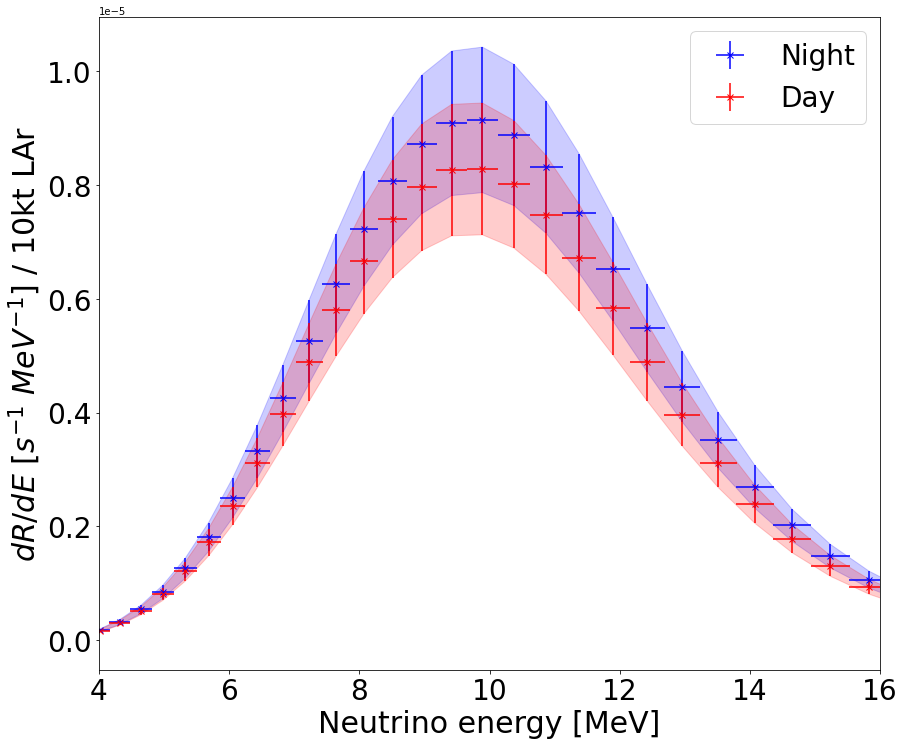

5.349505953633537e-05 5.894188510702013e-05
[9.89089528]


In [35]:
plt.figure(figsize=(14,12))

#Gaussian function

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def f(x, A, B):
    return A*x + B

def R_errors(R, spect_perc, flux_perc, cross_perc):
    R_var = R**2*((spect_perc/100)**2+(flux_perc/100)**2+(cross_perc/100)**2+(effic_perc/100)**2)
    return np.sqrt(R_var)

fac_S = np.sqrt(2*np.pi)*inEres
sigma = resol

intnight_E = np.array([])
intday_E = np.array([])

for i in range(0, len(xdata)):
    
    convener = xdata
    convE = xdata[i]
    
    nightval = eff*nt*numflux*fluxspec*crosssec*Spn*gauss_function(convener, fac_S/convE, convE, inEres*convE)*fac
    nightval[np.isnan(nightval)] = 0
    intnight_E = np.append(intnight_E, sum(nightval))
    
for i in range(0, len(xdata)):
    
    convener = xdata
    convE = xdata[i]
    
    dayval = eff*nt*numflux*fluxspec*crosssec*Spd*gauss_function(convener, fac_S/convE, convE, inEres*convE)*fac
    
    dayval[np.isnan(dayval)] = 0
    intday_E = np.append(intday_E, sum(dayval))
    
#Errors
Nerror = R_errors(intnight_E, spect_perc, flux_perc, cross_perc)
Derror = R_errors(intday_E, spect_perc, flux_perc, cross_perc)

plt.errorbar(xdata, intnight_E, xerr=uncer, linestyle='',yerr=Nerror, marker="x", color="blue", label='Night')
plt.errorbar(xdata, intday_E, xerr=uncer, linestyle='',yerr=Derror, marker="x", color="red", label='Day')

plt.fill_between(xdata, (intnight_E)+Nerror, (intnight_E)-Nerror, color='blue', alpha=0.2)
plt.fill_between(xdata, (intday_E)+Derror, (intday_E)-Derror, color='red', alpha=0.2)

plt.xlabel('Neutrino energy [MeV]',fontsize=30)
plt.xticks(fontsize=28)

plt.ylabel('$dR/dE$ [$s^{-1}\ MeV^{-1}$] / $10$kt LAr',fontsize=30)
plt.yticks(fontsize=28)
plt.legend(fontsize=28)

plt.xlim(4,16)

#plt.ylim(0, 1500)
#plt.title("SNOwGLoBES", fontsize=20)

plt.savefig('../figures/sensitiv.png', bbox_inches='tight')
plt.show()

rateday = np.sum(intday_E*bwidth)
ratenight = np.sum(intnight_E*bwidth)
print(rateday, ratenight)
print(xdata[intnight_E == np.max(intnight_E)])

In [36]:
def asymerr(night, day, back):
    
    tempasymmetry = 2*(night-day)/(night+day+2*back)
    
    tempuncer = np.sqrt((4*(day+back)/(night+day+back)**2)**2*(day) + (4*(night+back)/(night+day+back)**2)**2*(night) 
                        +(4*(night-day)/(night+day+back)**2)**2*(back))
    
    sumasym = np.sum((tempasymmetry/tempuncer**2)[~np.isnan(tempasymmetry/tempuncer**2)])
    sumuncer = np.sum((1/tempuncer**2)[~np.isinf(1/tempuncer**2)])
    
    asymoutput = (sumasym/sumuncer)
    uncerstat = np.sqrt(1/sumuncer)
    
    uncersys = 0
    
    unceroutput = np.sqrt((uncerstat/asymoutput)**2 + uncersys**2)
    
    return asymoutput*100, asymoutput*unceroutput*100, tempasymmetry, tempuncer

back = 1e0
years = 10
expo = years*3.14e7*4

asymfin, uncerfin, asymarray, uncerarray = asymerr(ratenight*expo, rateday*expo, back)

print("Night-day asymmetry:", asymfin, "+/-", uncerfin, "%")
print(rateday*expo/(4*5), ratenight*expo/(4*5))

Night-day asymmetry: 9.688538673680283 +/- 0.5340772335993107 %
3359.4897388818617 3701.5503847208647
